In [1]:
import pandas as pd
import numpy as np

import wrangle as w
import explore as e

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

from sklearn.metrics import mean_squared_error
from math import sqrt 


import warnings 
warnings.filterwarnings('ignore')

In [2]:
mon_sa = w.sales('monthly_home_sales_sa.csv')
mon_aus = w.sales('monthly_aus.csv')
mon_dal = w.sales('monthly_dal.csv')
mon_hou = w.sales('monthly_hou.csv')

In [3]:
df = e.comparing_markets(mon_sa,mon_aus,mon_dal, mon_hou, keys=['san antonio', 'austin', 'dallas', 'houston'])

In [4]:
mon_aus

,sales,dollar_volume,average_price,median_price,total_listings,months_inventory
date,,,,,,
1990-01-01,558,46937286,84117,71000,4391,7.9
1990-02-01,444,37056240,83460,71199,4343,8.7
1990-03-01,431,34722653,80563,72497,4459,9.3
1990-04-01,569,34616822,60838,71998,4545,9.1
1990-05-01,549,44907102,81798,73694,4731,9.3
...,...,...,...,...,...,...
2022-11-01,2055,1183522245,575923,464000,8738,3.0
2022-12-01,2508,1384506103,552036,450000,7416,2.6
2023-01-01,1630,907597030,556808,449990,7243,2.6


In [5]:
df.head()

,san antonio,austin,dallas,houston
date,,,,
1990-01-01,73352,84117,105280,85771
1990-02-01,75637,83460,106998,88640
1990-03-01,81494,80563,104479,86125
1990-04-01,89849,60838,106941,90907
1990-05-01,90087,81798,111997,86045
...,...,...,...,...
2022-11-01,367292,575923,474614,399020
2022-12-01,373319,552036,454773,404350
2023-01-01,365480,556808,457712,378553


## Split Data

In [6]:
def split_data_explore(df):
    '''
    This function takes in a clean df and splits it to train, validate, and test to model upon
    '''
    train_size = int(round(df.shape[0] * 0.5))
    validate_size = int(round(df.shape[0] * 0.3))
    test_size = int(round(df.shape[0] * 0.2))
    
    
    validate_end_index = train_size + validate_size
    
    train = df[:train_size]
    validate = df[train_size:validate_end_index]
    test = df[validate_end_index:]

    
    return train, validate, test

In [7]:
train, validate, test = split_data_explore(df)

In [8]:
train.shape, validate.shape, test.shape

((200, 4), (120, 4), (79, 4))

In [9]:
train

,san antonio,austin,dallas,houston
date,,,,
1990-01-01,73352,84117,105280,85771
1990-02-01,75637,83460,106998,88640
1990-03-01,81494,80563,104479,86125
1990-04-01,89849,60838,106941,90907
1990-05-01,90087,81798,111997,86045
...,...,...,...,...
2006-04-01,163254,226997,189590,192849
2006-05-01,171978,228908,204039,200981
2006-06-01,177577,234463,206188,210126


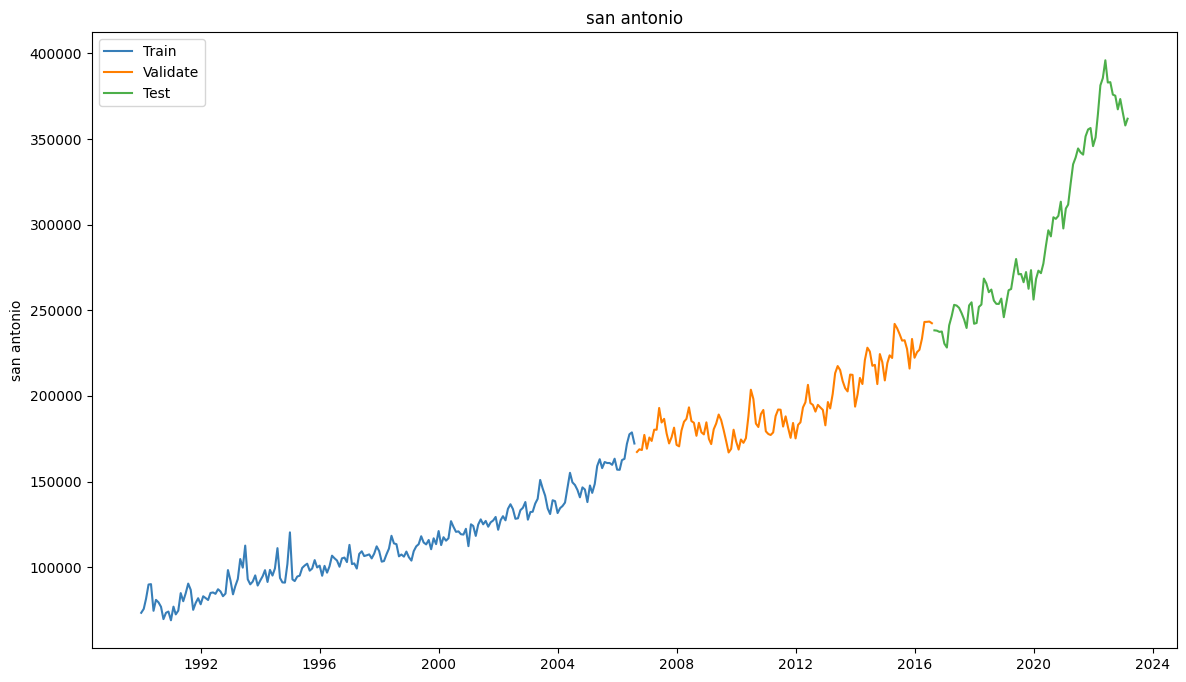

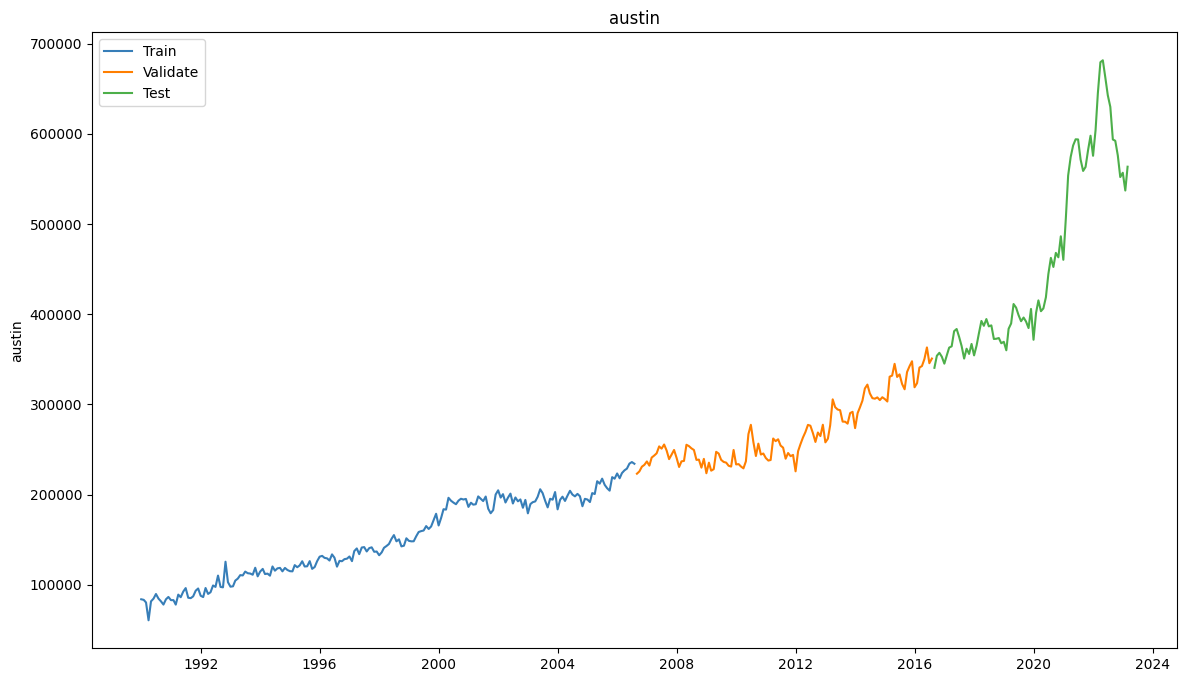

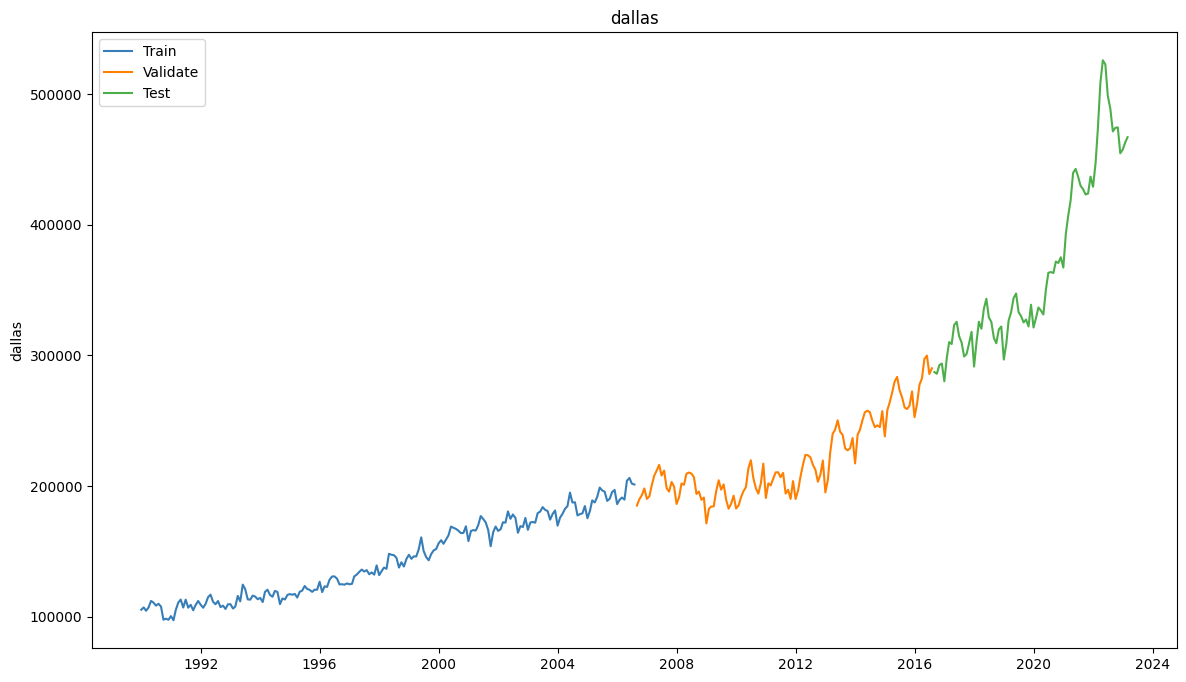

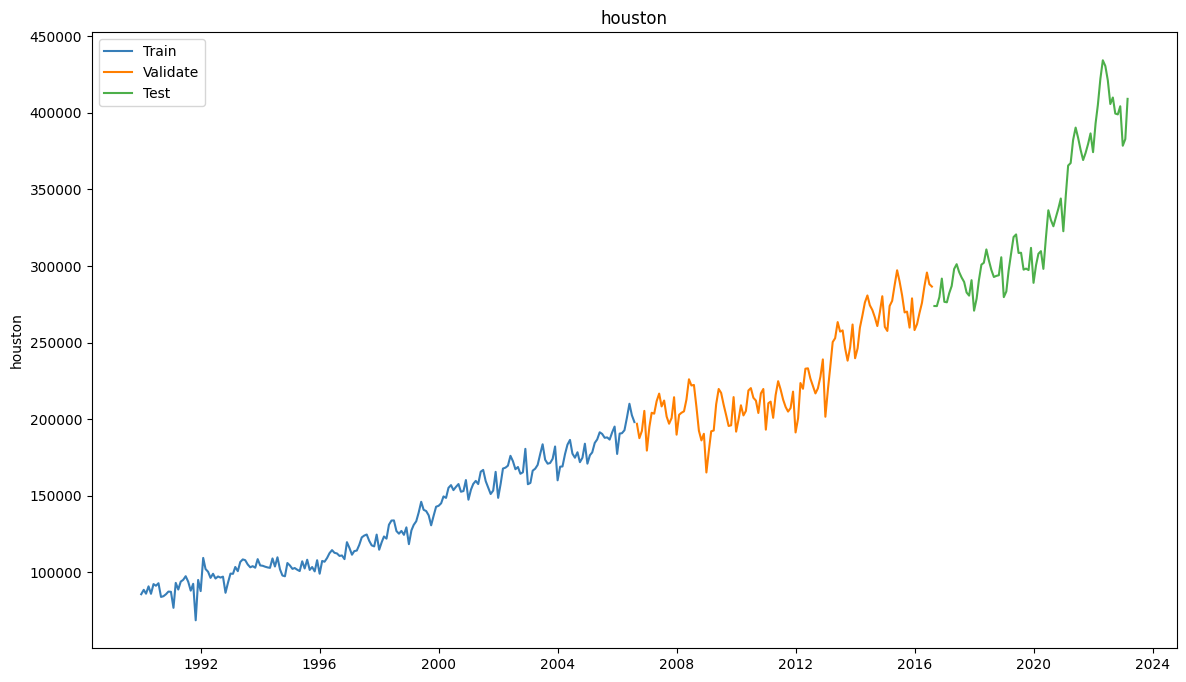

In [10]:
# Viz our train dataset
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [11]:
# creating our baseline 
period=3
train['san antonio'].rolling(period).mean()

date
1990-01-01              NaN
1990-02-01              NaN
1990-03-01     76827.666667
1990-04-01     82326.666667
1990-05-01     87143.333333
                  ...      
2006-04-01    160862.333333
2006-05-01    165911.000000
2006-06-01    170936.333333
2006-07-01    176075.333333
2006-08-01    176144.666667
Name: san antonio, Length: 200, dtype: float64

In [12]:
period=3
train['san antonio'].rolling(period).mean()[-1]

176144.66666666666

In [13]:
# Saving the last 3 month moving average for each column
period=3
rolling_san_antonio = round(train['san antonio'].rolling(period).mean()[-1], 2)
rolling_austin = round(train['austin'].rolling(period).mean()[-1], 2)
rolling_dallas = round(train['dallas'].rolling(period).mean()[-1], 2)
rolling_houston = round(train['houston'].rolling(period).mean()[-1], 2)
print(rolling_san_antonio, rolling_austin, rolling_dallas, rolling_houston) 

176144.67 234984.67 203037.67 203642.0


In [14]:
def make_baseline_predictions(san_antonio_col=None, austin_col=None, dallas_col = None, houston_col = None):
    yhat_df = pd.DataFrame({'san antonio': [san_antonio_col],
                           'austin': [austin_col],
                           'dallas': [dallas_col],
                           'houston': [houston_col]},
                          index=validate.index)
    return yhat_df

In [15]:
yhat_df = make_baseline_predictions(rolling_san_antonio, rolling_austin, rolling_dallas, rolling_houston)
yhat_df.head()

,san antonio,austin,dallas,houston
date,,,,
2006-09-01,176144.67,234984.67,203037.67,203642.0
2006-10-01,176144.67,234984.67,203037.67,203642.0
2006-11-01,176144.67,234984.67,203037.67,203642.0
2006-12-01,176144.67,234984.67,203037.67,203642.0
2007-01-01,176144.67,234984.67,203037.67,203642.0


In [16]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [17]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

san antonio -- RMSE: 28872


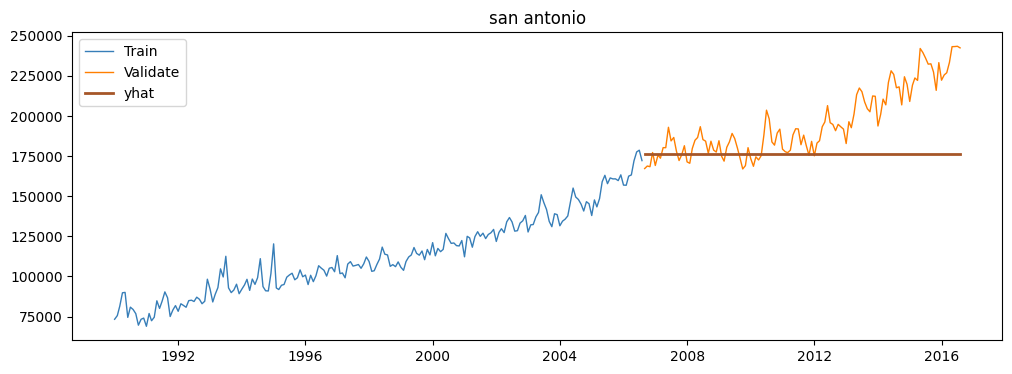

austin -- RMSE: 51244


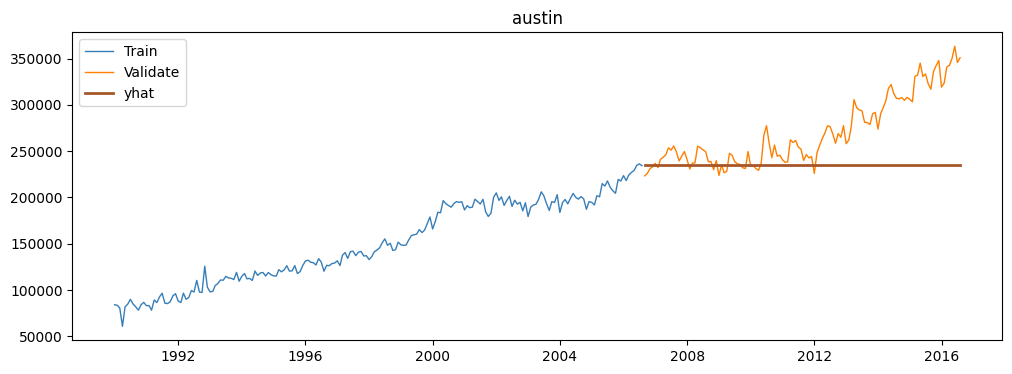

dallas -- RMSE: 34849


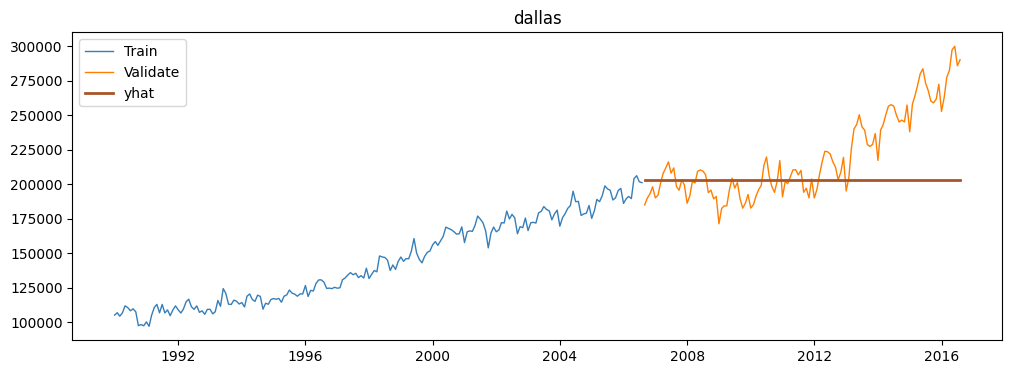

houston -- RMSE: 40410


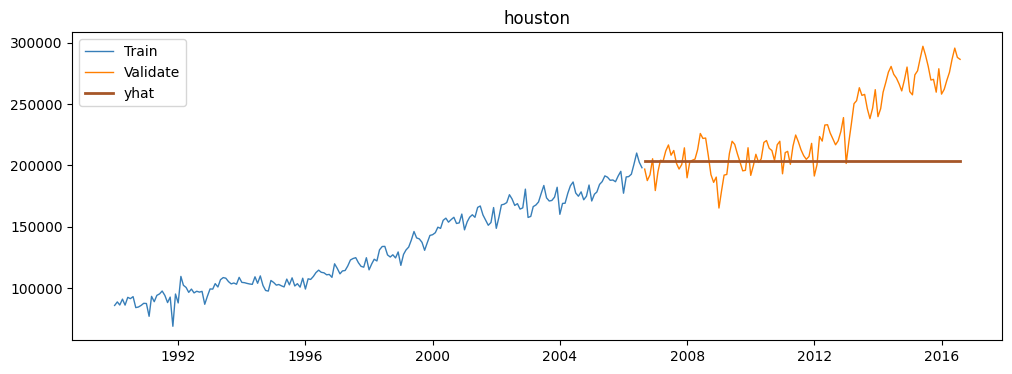

In [18]:
for col in train.columns:
    plot_and_eval(col)

In [19]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [20]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [21]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '1st_qtr_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,1st_qtr_avg,san antonio,28872.0
1,1st_qtr_avg,austin,51244.0
2,1st_qtr_avg,dallas,34849.0
3,1st_qtr_avg,houston,40410.0


In [22]:
evaluate('san antonio')

28872.0

In [23]:
rolls = []
periods = [1, 3, 6, 9, 12, 18, 24, 36]
cities = ['san antonio', 'austin', 'dallas', 'houston']

for num in periods:  
    rolling_san_antonio = round(train['san antonio'].rolling(num).mean()[-1], 2)
    rolling_austin = round(train['austin'].rolling(num).mean()[-1], 2)
    rolling_dallas = round(train['dallas'].rolling(num).mean()[-1], 2)
    rolling_houston = round(train['houston'].rolling(num).mean()[-1], 2)
    
    yhat_df = make_baseline_predictions(rolling_san_antonio, rolling_austin, rolling_dallas, rolling_houston)
    
    for city in cities:
        rmse = evaluate(city)
        rolls.append(rmse)

rolls_array = [rolls[i:i + len(cities)] for i in range(0, len(rolls), len(cities))]  # Reshape the rolls list

rolls_df = pd.DataFrame(rolls_array, index=periods, columns=cities)
#rolls_df.columns.name = 'cities'
rolls_df.index.name = 'periods_in_months'

rolls_df

,san antonio,austin,dallas,houston
periods_in_months,,,,
1,31693.0,51714.0,35803.0,44002.0
3,28872.0,51244.0,34849.0,40410.0
6,32563.0,54205.0,36983.0,43245.0
9,35695.0,56918.0,38578.0,45938.0
12,37032.0,60158.0,39339.0,47153.0
18,39770.0,63673.0,39737.0,48947.0
24,43686.0,68593.0,42260.0,51901.0
36,48856.0,73362.0,44468.0,55347.0


In [24]:
best_period = []
cities = ['san antonio', 'austin', 'dallas', 'houston']

for city in cities:
    rmse = evaluate(city)
    best_period.append(rmse)

pd.DataFrame(best_period, index = cities, columns ={'RMSE'}).T  

,san antonio,austin,dallas,houston
RMSE,48856.0,73362.0,44468.0,55347.0


In [25]:
eval_df

,model_type,target_var,rmse
0,1st_qtr_avg,san antonio,28872.0
1,1st_qtr_avg,austin,51244.0
2,1st_qtr_avg,dallas,34849.0
3,1st_qtr_avg,houston,40410.0


In [26]:
rolls = []
periods = [1, 3, 6, 9, 12, 18, 24, 36]
cities = ['san antonio', 'austin', 'dallas', 'houston']
model_types = ['1_month_avg', '1_qtr_avg', '2_qtr_avg', '3_qtr_avg',
               '1_yr_avg', '1.5_yr_avg', '2_yr_avg', '3_yr_avg']

for num in periods:  
    rolling_san_antonio = round(train['san antonio'].rolling(num).mean()[-1], 2)
    rolling_austin = round(train['austin'].rolling(num).mean()[-1], 2)
    rolling_dallas = round(train['dallas'].rolling(num).mean()[-1], 2)
    rolling_houston = round(train['houston'].rolling(num).mean()[-1], 2)
    
    yhat_df = make_baseline_predictions(rolling_san_antonio, rolling_austin, rolling_dallas, rolling_houston)
    
    for city in cities:
        rmse = evaluate(city)
        rolls.append([model_types[periods.index(num)], city, rmse])

rolls_df = pd.DataFrame(rolls, columns=['model_type', 'target_var', 'rmse'])

rolls_df

,model_type,target_var,rmse
0,1_month_avg,san antonio,31693.0
1,1_month_avg,austin,51714.0
2,1_month_avg,dallas,35803.0
3,1_month_avg,houston,44002.0
4,1_qtr_avg,san antonio,28872.0
5,1_qtr_avg,austin,51244.0
6,1_qtr_avg,dallas,34849.0
7,1_qtr_avg,houston,40410.0
8,2_qtr_avg,san antonio,32563.0
9,2_qtr_avg,austin,54205.0


In [27]:
#baseline models
eval_df = eval_df.append(rolls_df, ignore_index = True)
eval_df = eval_df.iloc[4:].reset_index(drop = True)
eval_df

,model_type,target_var,rmse
0,1_month_avg,san antonio,31693.0
1,1_month_avg,austin,51714.0
2,1_month_avg,dallas,35803.0
3,1_month_avg,houston,44002.0
4,1_qtr_avg,san antonio,28872.0
5,1_qtr_avg,austin,51244.0
6,1_qtr_avg,dallas,34849.0
7,1_qtr_avg,houston,40410.0
8,2_qtr_avg,san antonio,32563.0
9,2_qtr_avg,austin,54205.0


In [28]:
eval_df.head()

,model_type,target_var,rmse
0,1_month_avg,san antonio,31693.0
1,1_month_avg,austin,51714.0
2,1_month_avg,dallas,35803.0
3,1_month_avg,houston,44002.0
4,1_qtr_avg,san antonio,28872.0


In [29]:
#best baseline model per city (1st qtr avg gives us the best baseline model)
best_baseline = eval_df.loc[eval_df.groupby('target_var')['rmse'].idxmin()]
best_baseline

,model_type,target_var,rmse
5,1_qtr_avg,austin,51244.0
6,1_qtr_avg,dallas,34849.0
7,1_qtr_avg,houston,40410.0
4,1_qtr_avg,san antonio,28872.0


In [30]:
period = 3 
rolling_san_antonio = round(train['san antonio'].rolling(period).mean()[-1], 2)
rolling_austin = round(train['austin'].rolling(period).mean()[-1], 2)
rolling_dallas = round(train['dallas'].rolling(period).mean()[-1], 2)
rolling_houston = round(train['houston'].rolling(period).mean()[-1], 2)


yhat_df = make_baseline_predictions(rolling_san_antonio, rolling_austin,
                                    rolling_dallas, rolling_houston)

san antonio -- RMSE: 28872


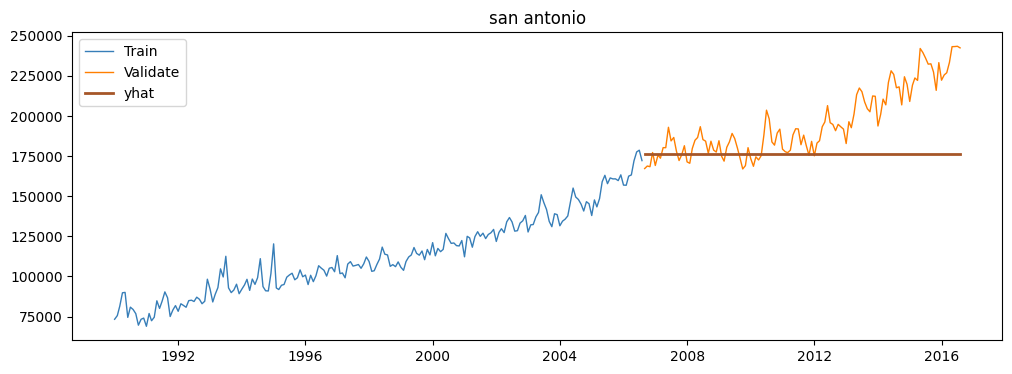

austin -- RMSE: 51244


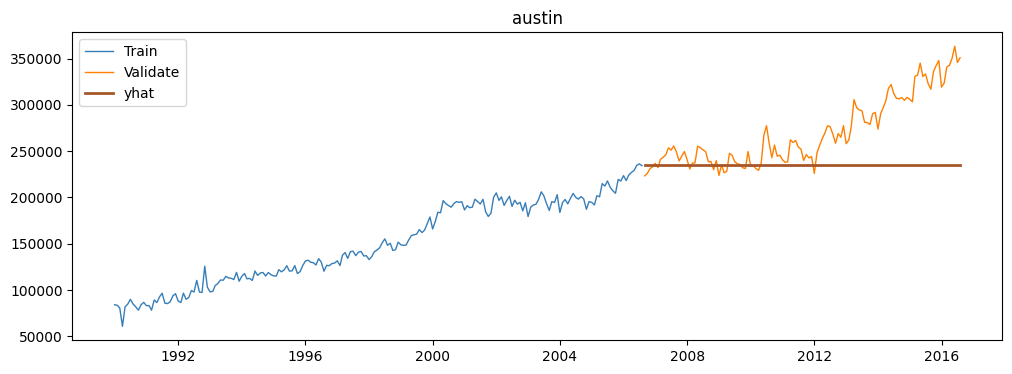

dallas -- RMSE: 34849


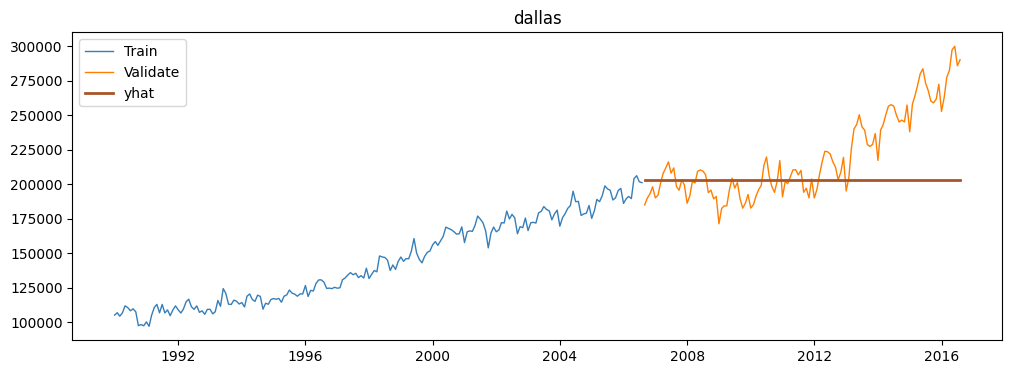

houston -- RMSE: 40410


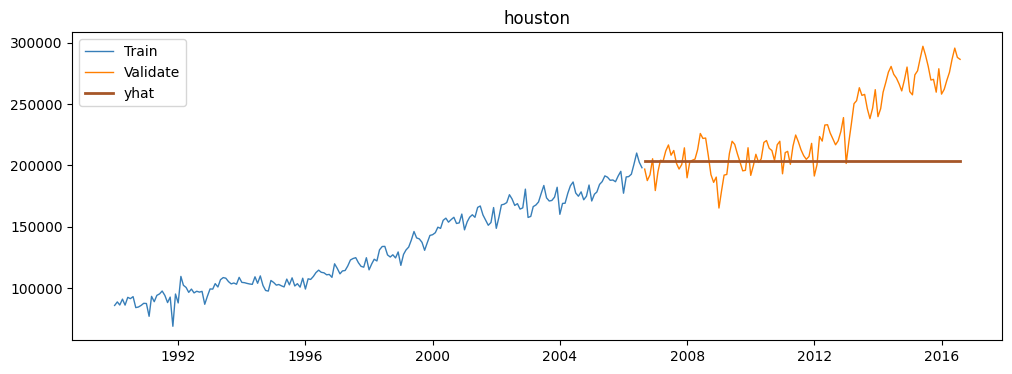

In [31]:
#baseline model viz
for col in train.columns:
    plot_and_eval(col)

# Non-Baseline Models

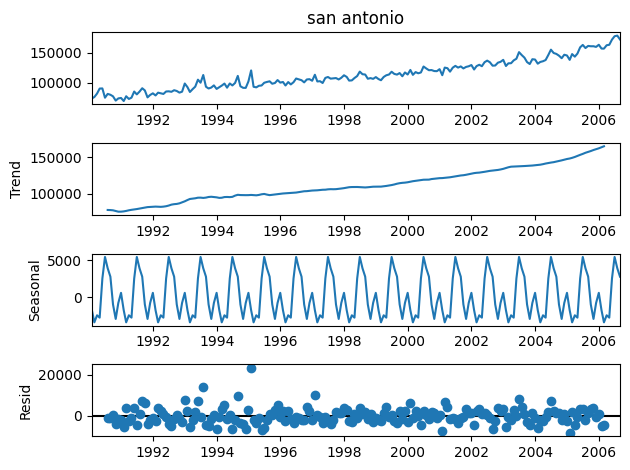

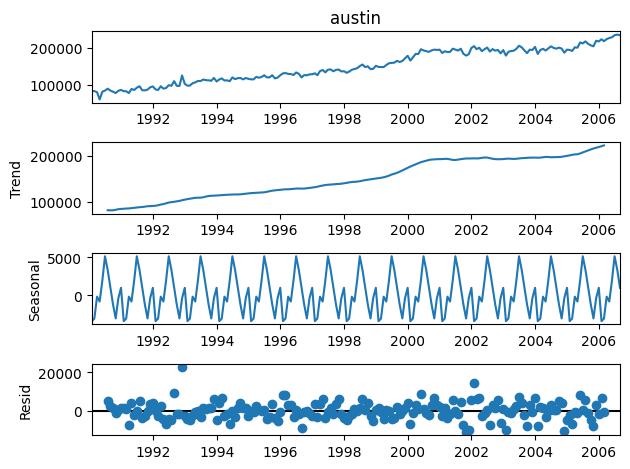

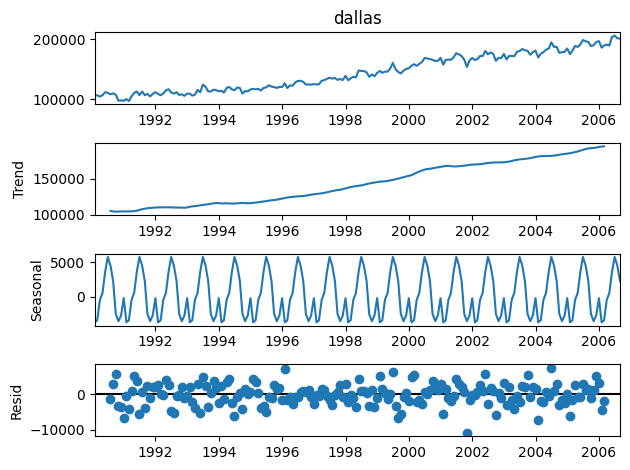

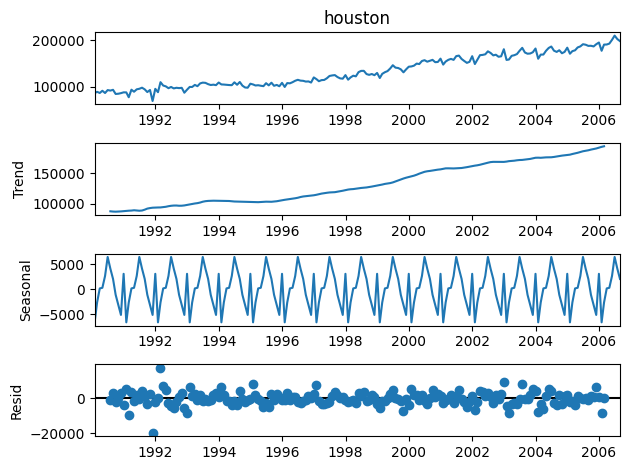

In [32]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [33]:
train

,san antonio,austin,dallas,houston
date,,,,
1990-01-01,73352,84117,105280,85771
1990-02-01,75637,83460,106998,88640
1990-03-01,81494,80563,104479,86125
1990-04-01,89849,60838,106941,90907
1990-05-01,90087,81798,111997,86045
...,...,...,...,...
2006-04-01,163254,226997,189590,192849
2006-05-01,171978,228908,204039,200981
2006-06-01,177577,234463,206188,210126


In [34]:
col = 'san antonio' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

In [35]:
# fit the Holt object
model = model.fit(optimized=True)

In [36]:
yhat_san_antonio = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [37]:
validate.shape


(120, 4)

In [38]:
yhat_san_antonio

2006-09-01    175022.306949
2006-10-01    175598.007641
2006-11-01    176167.951326
2006-12-01    176732.195574
2007-01-01    177290.797380
                  ...      
2016-04-01    214468.790255
2016-05-01    214650.026114
2016-06-01    214829.449614
2016-07-01    215007.078879
2016-08-01    215182.931852
Freq: MS, Length: 120, dtype: float64

In [39]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

In [40]:
yhat_df

,san antonio,austin,dallas,houston
date,,,,
2006-09-01,175022.31,235606.83,201824.34,201896.03
2006-10-01,175598.01,236555.05,202050.24,202582.55
2006-11-01,176167.95,237493.78,202273.87,203262.20
2006-12-01,176732.20,238423.13,202495.27,203935.05
2007-01-01,177290.80,239343.18,202714.46,204601.18
...,...,...,...,...
2016-04-01,214468.79,300577.78,217302.39,248935.43
2016-05-01,214650.03,300876.28,217373.50,249151.55
2016-06-01,214829.45,301171.80,217443.90,249365.51


san antonio -- RMSE: 14037


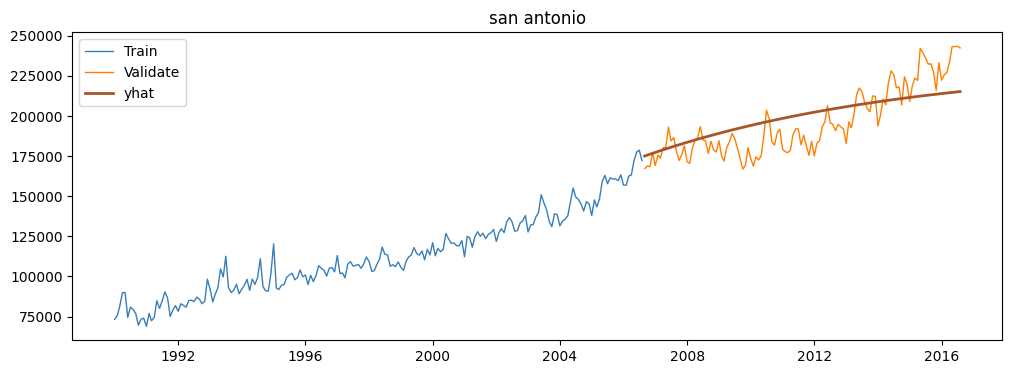

austin -- RMSE: 24811


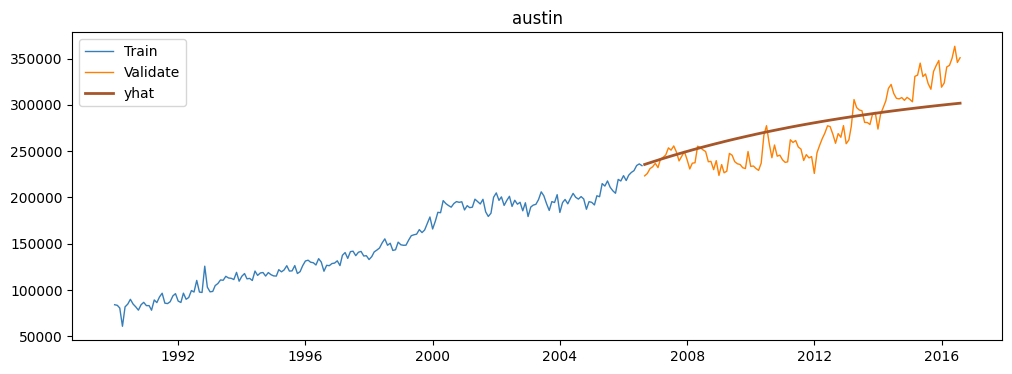

dallas -- RMSE: 28510


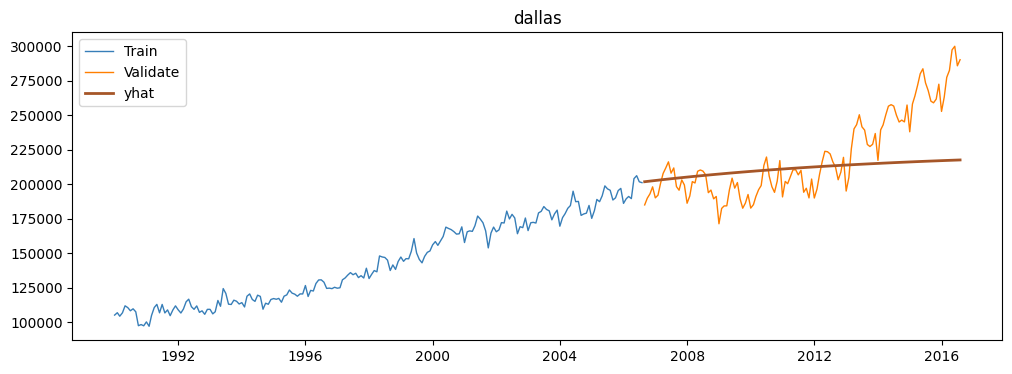

houston -- RMSE: 22183


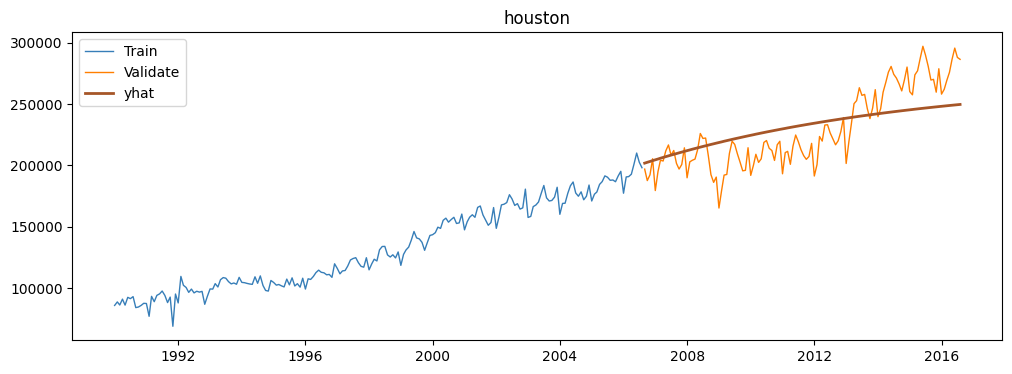

In [41]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [42]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [43]:
eval_df.sort_values('rmse')

,model_type,target_var,rmse
32,holts_optimized,san antonio,14037.0
35,holts_optimized,houston,22183.0
33,holts_optimized,austin,24811.0
34,holts_optimized,dallas,28510.0
4,1_qtr_avg,san antonio,28872.0
0,1_month_avg,san antonio,31693.0
8,2_qtr_avg,san antonio,32563.0
6,1_qtr_avg,dallas,34849.0
12,3_qtr_avg,san antonio,35695.0
2,1_month_avg,dallas,35803.0


In [44]:
#san antonio models
hst_san_antonio_fit1 = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods=3, trend='add', seasonal='add').fit()
hst_san_antonio_fit2 = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods=3, trend='add', seasonal='mul').fit()
hst_san_antonio_fit3 = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods=3, trend='add', seasonal='add', damped=True).fit()
hst_san_antonio_fit4 = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods=3, trend='add', seasonal='mul', damped=True).fit()

#austin models
hst_austin_fit1 = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods=3, trend='add', seasonal='add').fit()
hst_austin_fit2 = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods=3, trend='add', seasonal='mul').fit()
hst_austin_fit3 = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods=3, trend='add', seasonal='add', damped=True).fit()
hst_austin_fit4 = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods=3, trend='add', seasonal='mul', damped=True).fit()

In [45]:
results_san_antonio_austin = pd.DataFrame({'model':['hst_san_antonio_fit1','hst_san_antonio_fit2',
                                        'hst_san_antonio_fit3','hst_san_antonio_fit4',
                                        'hst_austin_fit1', 'hst_austin_fit2',
                                        'hst_austin_fit3', 'hst_austin_fit4'],
                              'SSE':[hst_san_antonio_fit1.sse, hst_san_antonio_fit2.sse,
                                     hst_san_antonio_fit3.sse, hst_san_antonio_fit4.sse,
                                     hst_austin_fit1.sse, hst_austin_fit2.sse, 
                                     hst_austin_fit3.sse, hst_austin_fit4.sse]})
results_san_antonio_austin

,model,SSE
0,hst_san_antonio_fit1,6.659828e+09
1,hst_san_antonio_fit2,6.721028e+09
2,hst_san_antonio_fit3,6.633158e+09
3,hst_san_antonio_fit4,6.694084e+09
4,hst_austin_fit1,7.526946e+09
5,hst_austin_fit2,7.701409e+09
6,hst_austin_fit3,7.597248e+09
7,hst_austin_fit4,7.867962e+09


In [46]:
## Models for dallas
hst_dallas_fit1 = ExponentialSmoothing(train['dallas'], seasonal_periods=3, trend='add', seasonal='add').fit()
hst_dallas_fit2 = ExponentialSmoothing(train['dallas'], seasonal_periods=3, trend='add', seasonal='mul').fit()
hst_dallas_fit3 = ExponentialSmoothing(train['dallas'], seasonal_periods=3, trend='add', seasonal='add', damped=True).fit()
hst_dallas_fit4 = ExponentialSmoothing(train['dallas'], seasonal_periods=3, trend='add', seasonal='mul', damped=True).fit()

# models for houston
hst_houston_fit1 = ExponentialSmoothing(train['houston'], seasonal_periods=3, trend='add', seasonal='add').fit()
hst_houston_fit2 = ExponentialSmoothing(train['houston'], seasonal_periods=3, trend='add', seasonal='mul').fit()
hst_houston_fit3 = ExponentialSmoothing(train['houston'], seasonal_periods=3, trend='add', seasonal='add', damped=True).fit()
hst_houston_fit4 = ExponentialSmoothing(train['houston'], seasonal_periods=3, trend='add', seasonal='mul', damped=True).fit()


In [47]:
results_dallas_houston = pd.DataFrame({'model':['hst_dallas_fit1','hst_dallas_fit2',
                                        'hst_dallas_fit3','hst_dallas_fit4',
                                        'hst_houston_fit1', 'hst_houston_fit2',
                                        'hst_houston_fit3', 'hst_houstonn_fit4'],
                              'SSE':[hst_dallas_fit1.sse, hst_dallas_fit2.sse,
                                     hst_dallas_fit3.sse, hst_dallas_fit4.sse,
                                     hst_houston_fit1.sse, hst_houston_fit2.sse, 
                                     hst_houston_fit3.sse, hst_houston_fit4.sse]})
results_dallas_houston

,model,SSE
0,hst_dallas_fit1,4.301369e+09
1,hst_dallas_fit2,4.343603e+09
2,hst_dallas_fit3,4.343998e+09
3,hst_dallas_fit4,4.338195e+09
4,hst_houston_fit1,6.593965e+09
5,hst_houston_fit2,6.557447e+09
6,hst_houston_fit3,6.613245e+09
7,hst_houstonn_fit4,6.576937e+09


In [48]:
results_cities = results_san_antonio_austin.append(results_dallas_houston, ignore_index = True)
results_cities.sort_values('SSE')

,model,SSE
8,hst_dallas_fit1,4.301369e+09
11,hst_dallas_fit4,4.338195e+09
9,hst_dallas_fit2,4.343603e+09
10,hst_dallas_fit3,4.343998e+09
13,hst_houston_fit2,6.557447e+09
15,hst_houstonn_fit4,6.576937e+09
12,hst_houston_fit1,6.593965e+09
14,hst_houston_fit3,6.613245e+09
2,hst_san_antonio_fit3,6.633158e+09
0,hst_san_antonio_fit1,6.659828e+09


In [49]:
places = ['antonio', 'austin', 'dallas', 'houston']
best_hs_models = []

for city in places:
    best_model = results_cities[results_cities['model'].str.contains(city)].sort_values('SSE').iloc[0]
    best_hs_models.append(best_model)

best_hs_models = pd.DataFrame(best_hs_models)
best_hs_models

,model,SSE
2,hst_san_antonio_fit3,6.633158e+09
4,hst_austin_fit1,7.526946e+09
8,hst_dallas_fit1,4.301369e+09
13,hst_houston_fit2,6.557447e+09


In [50]:
yhat_df = pd.DataFrame({'san antonio': hst_san_antonio_fit3.forecast(validate.shape[0]),
                        'austin': hst_austin_fit1.forecast(validate.shape[0]),
                        'dallas': hst_dallas_fit1.forecast(validate.shape[0]),
                        'houston': hst_houston_fit2.forecast(validate.shape[0])},
                       index=validate.index)
yhat_df

,san antonio,austin,dallas,houston
date,,,,
2006-09-01,176584.308526,236999.904181,203331.910249,206173.334010
2006-10-01,174465.749960,235267.362431,200917.901012,200963.989859
2006-11-01,177301.888068,236417.043873,204448.395374,203917.834277
2006-12-01,178627.112409,239078.716942,205287.043053,208605.747766
2007-01-01,176488.125804,237346.175192,202873.033816,203325.656684
...,...,...,...,...
2016-04-01,220904.672638,314262.247359,275212.947557,290707.329203
2016-05-01,223276.421520,315411.928800,278743.441919,294624.934404
2016-06-01,224141.900526,318073.601869,279582.089597,301037.470493


san antonio -- RMSE: 15305


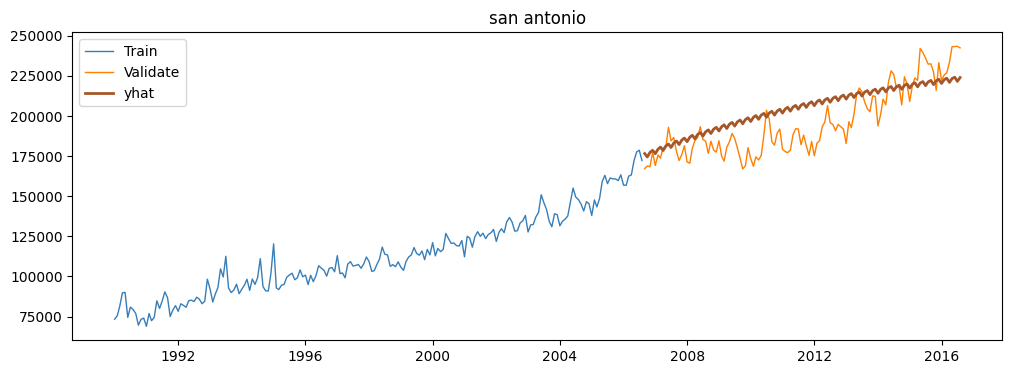

austin -- RMSE: 20731


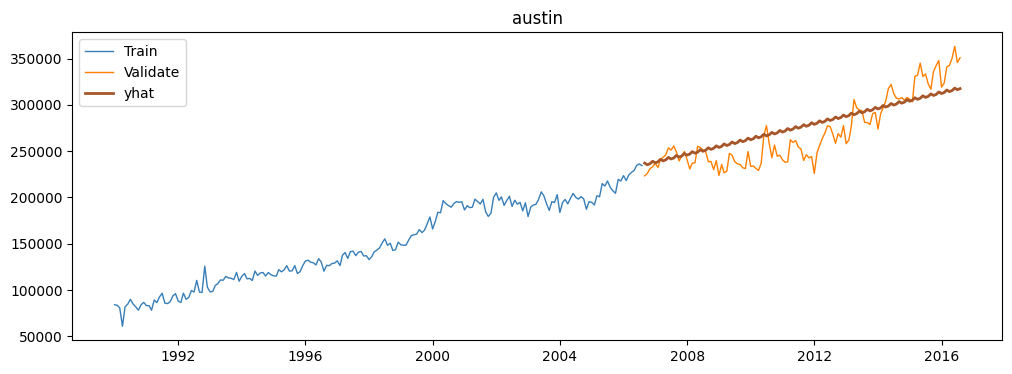

dallas -- RMSE: 26872


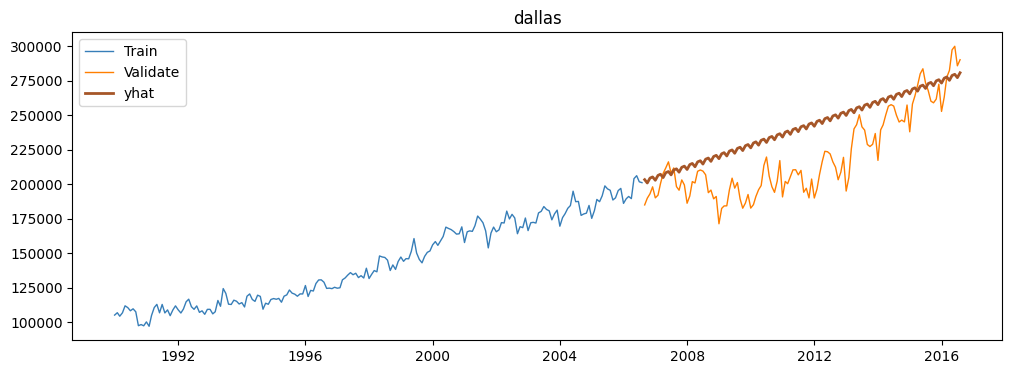

houston -- RMSE: 26663


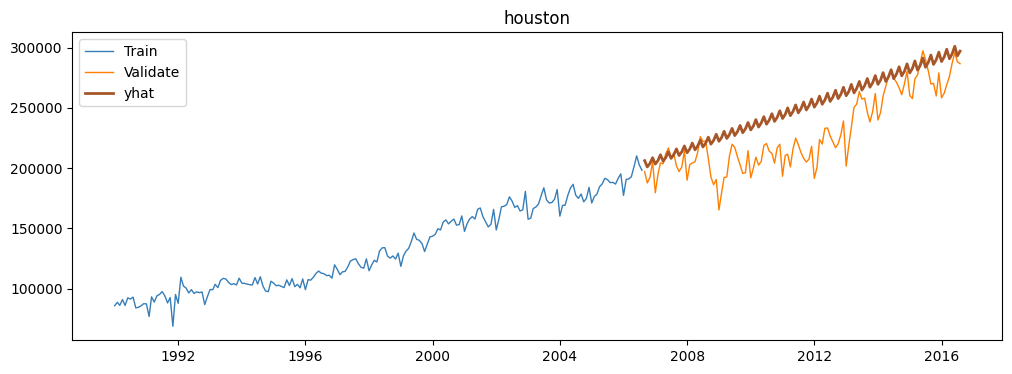

In [51]:
for col in train.columns:
    plot_and_eval(col)

In [52]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

In [53]:
eval_df.at[39, 'model_type'] = 'holts_seasonal_add_mul'
eval_df.at[36, 'model_type'] = 'holts_seasonal_add_add_damped'
eval_df.loc[4:7, 'model_type'] = '1_qtr_base'

In [54]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
32,holts_optimized,san antonio,14037.0
36,holts_seasonal_add_add_damped,san antonio,15305.0
37,holts_seasonal_add_add,austin,20731.0
35,holts_optimized,houston,22183.0
33,holts_optimized,austin,24811.0
39,holts_seasonal_add_mul,houston,26663.0
38,holts_seasonal_add_add,dallas,26872.0
34,holts_optimized,dallas,28510.0
4,1_qtr_base,san antonio,28872.0
0,1_month_avg,san antonio,31693.0


In [55]:
best_non_models = eval_df.loc[eval_df.groupby('target_var')['rmse'].idxmin()].sort_values('rmse').reset_index(drop= True)
best_non_models

,model_type,target_var,rmse
0,holts_optimized,san antonio,14037.0
1,holts_seasonal_add_add,austin,20731.0
2,holts_optimized,houston,22183.0
3,holts_seasonal_add_add,dallas,26872.0


In [56]:
best_base_models = eval_df.loc[4:7]
best_base_models

,model_type,target_var,rmse
4,1_qtr_base,san antonio,28872.0
5,1_qtr_base,austin,51244.0
6,1_qtr_base,dallas,34849.0
7,1_qtr_base,houston,40410.0


# Best Hyperparameters for Each City

San Antonio:<br>
- ex_model = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods= 12, trend='add', seasonal='add', damped = True).fit()
- RMSE = 13063

Austin:<br>
- aus_model = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods= 3, trend='add', seasonal='add').fit()
- RMSE: 20731

Dallas:<br>
- dal_model = sm.tsa.ExponentialSmoothing(train['dallas'], seasonal_periods= 12, trend='add', seasonal='add').fit()
- RMSE: 19222

Houston:<br>
- hou_model = sm.tsa.ExponentialSmoothing(train['houston'], seasonal_periods= 12, trend='add', seasonal='mul').fit()
- RMSE: 16334

In [57]:
# Adjusting hyperparameters to find best exponential smoothing model for each city


others=pd.DataFrame()

for i in range(3,13):
    #san antonio models
    hst_san_antonio_fit1 = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods=i, trend='add', seasonal='add').fit()
    hst_san_antonio_fit2 = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods=i, trend='add', seasonal='mul').fit()
    hst_san_antonio_fit3 = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods=i, trend='add', seasonal='add', damped=True).fit()
    hst_san_antonio_fit4 = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods=i, trend='add', seasonal='mul', damped=True).fit()

    #austin models
    hst_austin_fit1 = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods=i, trend='add', seasonal='add').fit()
    hst_austin_fit2 = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods=i, trend='add', seasonal='mul').fit()
    hst_austin_fit3 = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods=i, trend='add', seasonal='add', damped=True).fit()
    hst_austin_fit4 = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods=i, trend='add', seasonal='mul', damped=True).fit()
    
    
    results_san_antonio_austin = pd.DataFrame({'model':['hst_san_antonio_fit1','hst_san_antonio_fit2',
                                        'hst_san_antonio_fit3','hst_san_antonio_fit4',
                                        'hst_austin_fit1', 'hst_austin_fit2',
                                        'hst_austin_fit3', 'hst_austin_fit4'],
                              'SSE':[hst_san_antonio_fit1.sse, hst_san_antonio_fit2.sse,
                                     hst_san_antonio_fit3.sse, hst_san_antonio_fit4.sse,
                                     hst_austin_fit1.sse, hst_austin_fit2.sse, 
                                     hst_austin_fit3.sse, hst_austin_fit4.sse]})
    others = others.append(results_san_antonio_austin, ignore_index=True)

In [58]:
best_hs_models

,model,SSE
2,hst_san_antonio_fit3,6.633158e+09
4,hst_austin_fit1,7.526946e+09
8,hst_dallas_fit1,4.301369e+09
13,hst_houston_fit2,6.557447e+09


In [59]:
others.at[72, 'model'] = 'example_model'    

In [60]:
best_aus = others[others['model'].str.contains('austin')].sort_values('SSE')
best_aus

,model,SSE
76,hst_austin_fit1,7.088022e+09
78,hst_austin_fit3,7.233785e+09
28,hst_austin_fit1,7.378454e+09
30,hst_austin_fit3,7.431126e+09
4,hst_austin_fit1,7.526946e+09
77,hst_austin_fit2,7.565629e+09
6,hst_austin_fit3,7.597248e+09
12,hst_austin_fit1,7.627151e+09
5,hst_austin_fit2,7.701409e+09
79,hst_austin_fit4,7.720189e+09


In [61]:
others.loc[70:79]

,model,SSE
70,hst_austin_fit3,8.031069e+09
71,hst_austin_fit4,9.299874e+09
72,example_model,4.834135e+09
73,hst_san_antonio_fit2,4.976502e+09
74,hst_san_antonio_fit3,4.891992e+09
75,hst_san_antonio_fit4,5.035139e+09
76,hst_austin_fit1,7.088022e+09
77,hst_austin_fit2,7.565629e+09
78,hst_austin_fit3,7.233785e+09
79,hst_austin_fit4,7.720189e+09


In [62]:
ex_model = sm.tsa.ExponentialSmoothing(train['san antonio'], seasonal_periods= 12, trend='add', seasonal='add', damped = True).fit()
ex_model.sse

4891992217.759254

In [63]:
aus_model = sm.tsa.ExponentialSmoothing(train['austin'], seasonal_periods= 3, trend='add', seasonal='add').fit()
aus_model.sse

7526945914.936342

In [64]:
dal_model = sm.tsa.ExponentialSmoothing(train['dallas'], seasonal_periods= 12, trend='add', seasonal='add').fit()
dal_model.sse

2679441103.4233966

In [65]:
hou_model = sm.tsa.ExponentialSmoothing(train['houston'], seasonal_periods= 12, trend='add', seasonal='mul').fit()
hou_model.sse

3859932428.5837812

In [66]:
yhat_df = pd.DataFrame({'san antonio': ex_model.forecast(validate.shape[0]),
                        'austin': aus_model.forecast(validate.shape[0]),
                        'dallas': dal_model.forecast(validate.shape[0]),
                        'houston': hou_model.forecast(validate.shape[0])},
                        index=validate.index)
yhat_df

,san antonio,austin,dallas,houston
date,,,,
2006-09-01,170320.684883,236999.904181,194509.172893,198559.254407
2006-10-01,169105.991855,235267.362431,194284.340040,194589.124803
2006-11-01,171810.872913,236417.043873,196955.839299,196197.653773
2006-12-01,173544.910221,239078.716942,200392.589998,204895.420306
2007-01-01,170026.698382,237346.175192,193832.621778,186834.880956
...,...,...,...,...
2016-04-01,219768.202004,314262.247359,259722.158554,275756.714507
2016-05-01,225848.527553,315411.928800,266351.339203,282439.777260
2016-06-01,229284.824974,318073.601869,269633.593142,291398.775777


san antonio -- RMSE: 13063


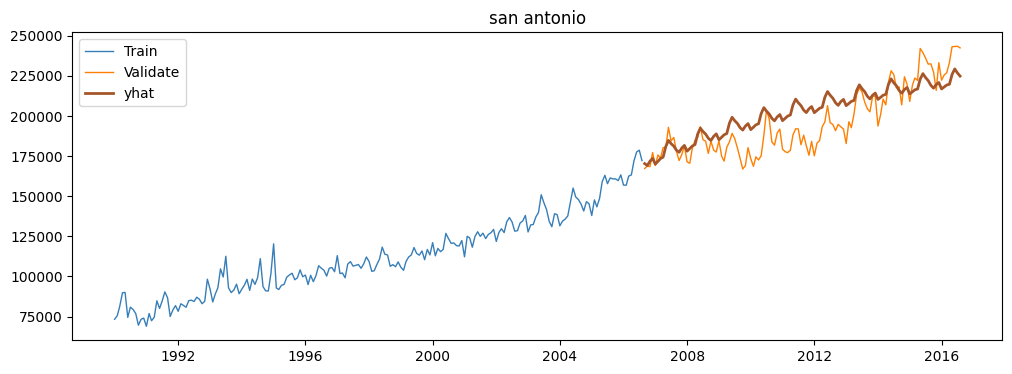

austin -- RMSE: 20731


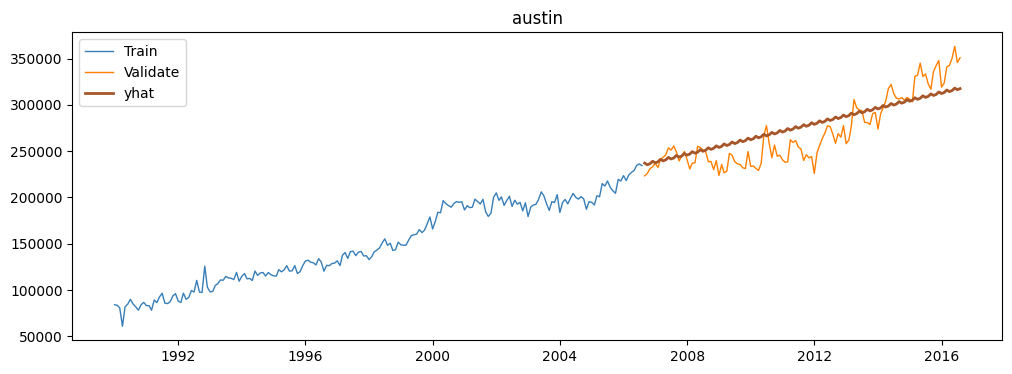

dallas -- RMSE: 19222


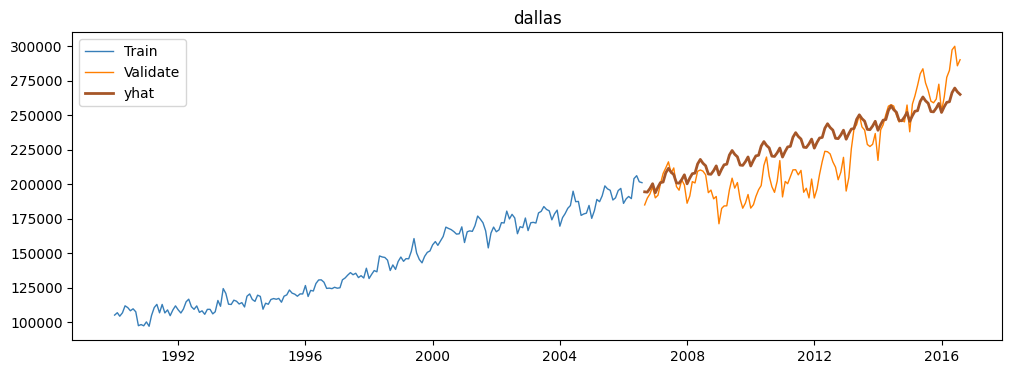

houston -- RMSE: 16334


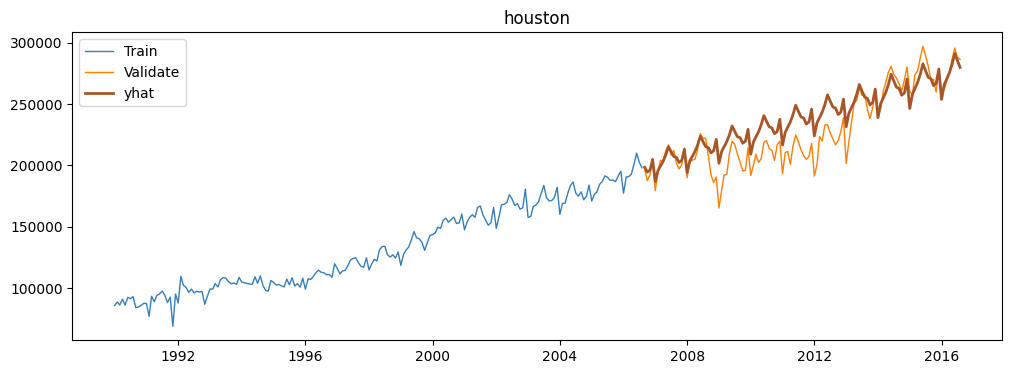

In [67]:
for col in train.columns:
    plot_and_eval(col)

In [68]:
df.head()

,san antonio,austin,dallas,houston
date,,,,
1990-01-01,73352,84117,105280,85771
1990-02-01,75637,83460,106998,88640
1990-03-01,81494,80563,104479,86125
1990-04-01,89849,60838,106941,90907
1990-05-01,90087,81798,111997,86045


In [69]:
bubble = df[(df.index >= pd.Timestamp('2000-01-01')) & (df.index <= pd.Timestamp('2015-01-01'))]
bubble = bubble[['san antonio', 'austin']]
bubble.head()

,san antonio,austin
date,,
2000-01-01,121085,165911
2000-02-01,112880,174355
2000-03-01,117478,183903
2000-04-01,115464,183501
2000-05-01,116866,196581


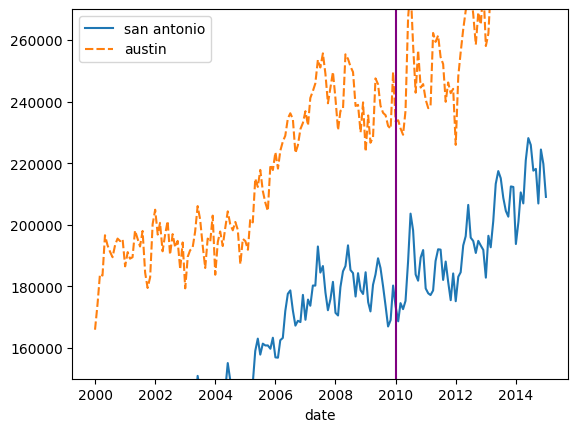

In [70]:
sns.lineplot(data = bubble)
plt.ylim(150000,270000)
plt.axvline(pd.Timestamp('2010-01-01'), color='purple', linestyle='-')


In [71]:
gfc = bubble[(bubble.index >= pd.Timestamp('2007-01-01')) & (bubble.index <= pd.Timestamp('2010-01-01'))]
gfc

,san antonio,austin
date,,
2007-01-01,169144,236856
2007-02-01,175700,232225
2007-03-01,173691,241142
2007-04-01,180260,243376
2007-05-01,180233,245866
2007-06-01,192940,253533
2007-07-01,184464,251054
2007-08-01,186590,255635
2007-09-01,177985,248907


In [72]:
#San Antonio 6-01-08 $193,307
#Austin 8-01-07 $255,635

gfc.loc[gfc['san antonio'].idxmax()], gfc.loc[gfc['austin'].idxmax()]

(san antonio    193307
 austin         253840
 Name: 2008-06-01 00:00:00, dtype: int64,
 san antonio    186590
 austin         255635
 Name: 2007-08-01 00:00:00, dtype: int64)

In [73]:
#san antonio 10-01-09 $166,960
#austin 1-1-09 $223,779

gfc.loc[gfc['san antonio'].idxmin()], gfc.loc[gfc['austin'].idxmin()]

(san antonio    166960
 austin         232070
 Name: 2009-10-01 00:00:00, dtype: int64,
 san antonio    184564
 austin         223779
 Name: 2009-01-01 00:00:00, dtype: int64)

### Notes
- Austin took 17 months to reach the bottom
- San Antonio took 16 months to reach the bottom
- This portion is me looking at a relationship with fibonacci extensions (come back to finish this portion)

In [74]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'optimized_holt_models', 
                            target_var = col)

In [75]:
eval_df

,model_type,target_var,rmse
0,1_month_avg,san antonio,31693.0
1,1_month_avg,austin,51714.0
2,1_month_avg,dallas,35803.0
3,1_month_avg,houston,44002.0
4,1_qtr_base,san antonio,28872.0
5,1_qtr_base,austin,51244.0
6,1_qtr_base,dallas,34849.0
7,1_qtr_base,houston,40410.0
8,2_qtr_avg,san antonio,32563.0
9,2_qtr_avg,austin,54205.0


In [76]:
best_overall_models = eval_df.iloc[40:]
best_overall_models

,model_type,target_var,rmse
40,optimized_holt_models,san antonio,13063.0
41,optimized_holt_models,austin,20731.0
42,optimized_holt_models,dallas,19222.0
43,optimized_holt_models,houston,16334.0


In [77]:
best_non_models

,model_type,target_var,rmse
0,holts_optimized,san antonio,14037.0
1,holts_seasonal_add_add,austin,20731.0
2,holts_optimized,houston,22183.0
3,holts_seasonal_add_add,dallas,26872.0


In [78]:
best_base_models

,model_type,target_var,rmse
4,1_qtr_base,san antonio,28872.0
5,1_qtr_base,austin,51244.0
6,1_qtr_base,dallas,34849.0
7,1_qtr_base,houston,40410.0


In [85]:
#a calculation to add a column for the difference in improvement of the models in final df
best_base_models['rmse'].iloc[0] - best_overall_models['rmse'].iloc[0]

15809.0

# Previous Cycle Model

In [88]:
df

,san antonio,austin,dallas,houston
date,,,,
1990-01-01,73352,84117,105280,85771
1990-02-01,75637,83460,106998,88640
1990-03-01,81494,80563,104479,86125
1990-04-01,89849,60838,106941,90907
1990-05-01,90087,81798,111997,86045
...,...,...,...,...
2022-11-01,367292,575923,474614,399020
2022-12-01,373319,552036,454773,404350
2023-01-01,365480,556808,457712,378553


In [96]:
# 34 years of data
df_yearly = df.resample('Y')['san antonio'].sum()
df_yearly = pd.DataFrame(df_yearly)
df_yearly.head()

,san antonio
date,
1990-12-31,939257
1991-12-31,955879
1992-12-31,1017595
1993-12-31,1134223
1994-12-31,1157974


In [97]:
train, validate, test = split_data_explore(df_yearly)
train.shape, validate.shape, test.shape

((17, 1), (10, 1), (7, 1))

In [111]:
train = df_yearly[:'2010']
validate = df_yearly['2011':'2017']
test = df_yearly['2018':]

print(train.shape)
print(validate.shape)
print(test.shape)

(21, 1)
(7, 1)
(6, 1)


In [113]:
train

,san antonio
date,
1990-12-31,939257
1991-12-31,955879
1992-12-31,1017595
1993-12-31,1134223
1994-12-31,1157974
1995-12-31,1198245
1996-12-31,1223612
1997-12-31,1279173
1998-12-31,1309028


In [112]:
train.diff(1)


,san antonio
date,
1990-12-31,NaN
1991-12-31,16622.0
1992-12-31,61716.0
1993-12-31,116628.0
1994-12-31,23751.0
1995-12-31,40271.0
1996-12-31,25367.0
1997-12-31,55561.0
1998-12-31,29855.0


In [123]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 
 
# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2004':'2010'] + train.diff(1).mean()
yhat_df

,san antonio
date,
2004-12-31,1779024.3
2005-12-31,1926564.3
2006-12-31,2084688.3
2007-12-31,2213671.3
2008-12-31,2236319.3
2009-12-31,2203599.3
2010-12-31,2264195.3


In [124]:
train.diff(1).mean()

san antonio    63092.3
dtype: float64

In [125]:
pd.concat([yhat_df.head(1), validate.head(1)])


,san antonio
date,
2004-12-31,1779024.3
2011-12-31,2196308.0


In [126]:
# set yhat_df to index of validate
yhat_df.index = validate.index

san antonio -- RMSE: 490799


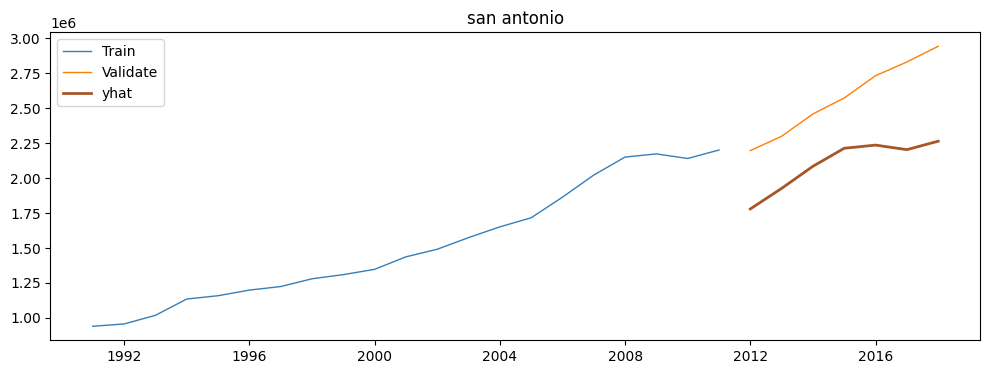

In [127]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)